# Case Study: Information Theory & Robust Randomness Extraction

**Author:** Jesús Garví | **Date:** 08/14

## 1. Introduction & Objectives
This notebook quantifies the information content of simple physical sources (coin, die, card decks) and applies it to the practical task of deriving a cryptographically strong 128-bit key. We evaluate entropy per event, demonstrate how to aggregate it across repeated trials, and implement the mathematically correct method for converting physical outcomes into a uniformly distributed key.

In [13]:

# --- SETUP CELL ---
!pip install -q numpy pandas matplotlib

## 2. Analysis: Comparing Entropy Sources
First, we will calculate and visualize the entropy density (the amount of information in "bits" per single event) for several common physical systems. This demonstrates the core principle that sources with more possible outcomes (a larger state space, Ω) are exponentially more efficient at generating randomness.

   Entropy per Event for Randomness Sources


,Entropy (bits per event)
Coin,1.000
Die (6-sided),2.585
Spanish Deck (40 cards),5.322
Standard Deck (52 cards),5.700


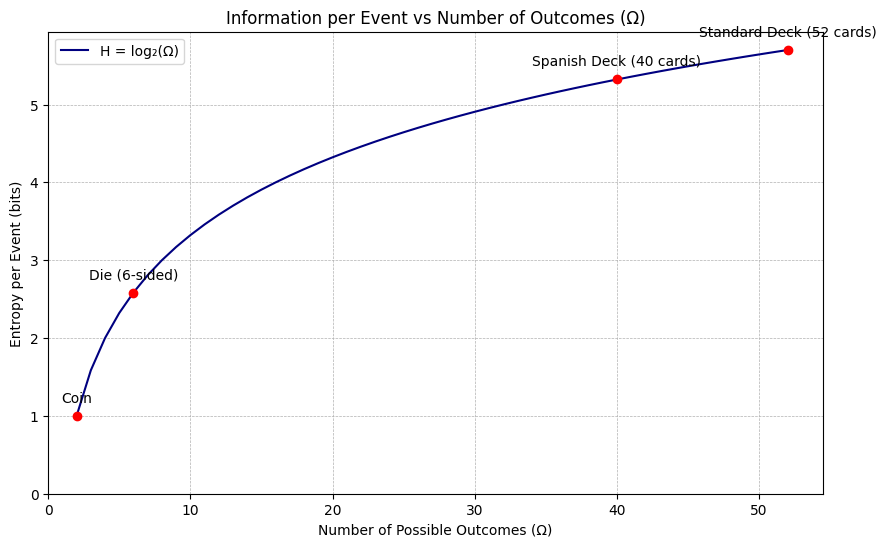


--- Theoretical Entropy for 25 Draws from a 40-card Deck ---
With replacement:    H_total = 133.048 bits  (Ω^n; Ω=40, n=25)
Without replacement: H_total = 118.909 bits  (P(Ω,n) = Ω!/(Ω-n)!)


In [11]:

# --- ANALYSIS CELL ---
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Entropy per event for representative sources
sources = {
    'Coin': 2,
    'Die (6-sided)': 6,
    'Spanish Deck (40 cards)': 40,
    'Standard Deck (52 cards)': 52
}
entropy_bits = {name: math.log2(omega) for name, omega in sources.items()}
entropy_df = pd.DataFrame.from_dict(entropy_bits, orient='index', columns=['Entropy (bits per event)'])

print("="*46)
print("   Entropy per Event for Randomness Sources")
print("="*46)
display(entropy_df.round(3))

# 2) Visualization: H = log2(Ω)
fig, ax = plt.subplots(figsize=(10, 6))
omegas = np.arange(2, 53, 1)
entropies = np.log2(omegas)
ax.plot(omegas, entropies, label='H = log₂(Ω)', color='navy')

# Highlight selected sources
points_df = entropy_df.reset_index().rename(columns={'index': 'Source'})
points_df['Omega'] = points_df['Source'].map(sources)
ax.scatter(points_df['Omega'], points_df['Entropy (bits per event)'], color='red', zorder=5)
for _, row in points_df.iterrows():
    ax.annotate(row['Source'], (row['Omega'], row['Entropy (bits per event)']),
                 textcoords="offset points", xytext=(0,10), ha='center')

ax.set_title('Information per Event vs Number of Outcomes (Ω)')
ax.set_xlabel('Number of Possible Outcomes (Ω)')
ax.set_ylabel('Entropy per Event (bits)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
plt.show()

# 3) 25 draws from a 40-card deck: with vs without replacement
base = 40
n_draws = 25

H_with = n_draws * math.log2(base)
# Without replacement: total microstates = P(base, n_draws) = base!/(base-n)!.
# Entropy = log2(P(base, n_draws))
def perm(n, k):
    if k < 0 or k > n:
        return 0
    p = 1
    for m in range(n-k+1, n+1):
        p *= m
    return p

M_wo = perm(base, n_draws)
H_wo = math.log2(M_wo) if M_wo > 0 else 0.0

print("\n--- Theoretical Entropy for 25 Draws from a 40-card Deck ---")
print(f"With replacement:    H_total = {H_with:.3f} bits  (Ω^n; Ω={base}, n={n_draws})")
print(f"Without replacement: H_total = {H_wo:.3f} bits  (P(Ω,n) = Ω!/(Ω-n)!)")

## 3. Simulation: Generating a 128-bit Key
This section implements two professional-grade methods for extracting a 128-bit key from the simulated draws: a theoretically pure method using rejection sampling and a pragmatically standard method using a cryptographic hash (SHA-256).

In [12]:
# --- SIMULATION CELL (CORRECT & ROBUST; FIXED draw_fn) ---
import secrets
import hashlib
import math

def perm(n, k):
    if k < 0 or k > n:
        return 0
    p = 1
    for m in range(n-k+1, n+1):
        p *= m
    return p

def draws_with_replacement(n_draws, base):
    if base <= 1:
        raise ValueError("Base must be >= 2.")
    return [secrets.randbelow(base) for _ in range(n_draws)]

def draws_without_replacement(n_draws, base):
    if n_draws > base:
        raise ValueError("Cannot draw without replacement when n_draws > base.")
    avail = list(range(base))
    draws = []
    for _ in range(n_draws):
        idx = secrets.randbelow(len(avail))
        draws.append(avail.pop(idx))
    return draws

def digits_to_int_base(draws, base):
    """Horner's method for sequences with replacement (base-Ω digits)."""
    x = 0
    for d in draws:
        x = x * base + int(d)
    return x

def rank_k_permutation(draws, base):
    """
    Rank a length-k sequence drawn without replacement from {0,...,base-1}
    in lexicographic order among all P(base,k) sequences.
    Returns an integer rank in [0, P(base,k)-1].
    """
    avail = list(range(base))
    k = len(draws)
    rank = 0
    for i, d in enumerate(draws):
        idx = avail.index(d)  # count of available elements smaller than d
        rank += idx * perm(base - i - 1, k - i - 1)
        avail.pop(idx)
    return rank

def acceptance_threshold(M, bits):
    two_b = 1 << bits
    return (M // two_b) * two_b, two_b

def uniform_key_from_physical_draws(n_draws=25, base=40, bits=128, with_replacement=True, verbose=True):
    """
    Generate a uniform 2^bits key from physical draws using rejection sampling.
    - Uses 'secrets' (CSPRNG) to simulate draws.
    - Maps the uniform outcome X in [0, M-1] to a uniform key in [0, 2^bits-1] by rejection sampling,
      where M = Ω^n (with replacement) or P(Ω,n) (without replacement).
    Returns: (hex_key, draws, attempts, accept_prob_estimate)
    """
    if with_replacement:
        M = base ** n_draws
        draw_fn = lambda: draws_with_replacement(n_draws, base)  # FIX: capture args
        to_int = lambda ds: digits_to_int_base(ds, base)
    else:
        M = perm(base, n_draws)
        draw_fn = lambda: draws_without_replacement(n_draws, base)  # FIX: capture args
        to_int = lambda ds: rank_k_permutation(ds, base)

    T, TWO_B = acceptance_threshold(M, bits)
    if T == 0:
        raise ValueError(
            f"Insufficient entropy for uniform {bits}-bit extraction: M={M} < 2^{bits}. "
            "Increase n_draws or switch to with-replacement (or use the hash-based extractor)."
        )

    accept_prob = T / M
    attempts = 0
    while True:
        attempts += 1
        ds = draw_fn()
        X = to_int(ds)
        if X < T:
            Y = X % TWO_B
            hex_key = f"{Y:0{bits//4}x}"
            if verbose:
                print(f"Accepted after {attempts} attempt(s); theoretical acceptance ≈ {accept_prob:.5f}")
                print(f"Draws: {ds}")
                print(f"Large integer X: {X}")
                print(f"Derived {bits}-bit key (hex): {hex_key}")
            return hex_key, ds, attempts, accept_prob

def hashed_key_from_physical_draws(n_draws=25, base=40, bits=128, with_replacement=True, verbose=True):
    """
    Generate a 2^bits key by hashing the draw sequence (SHA-256) and truncating.
    - Uses 'secrets' for draws.
    - Cryptographically standard (PRF/KDF style), not information-theoretically uniform, but sound in practice.
    """
    ds = draws_with_replacement(n_draws, base) if with_replacement else draws_without_replacement(n_draws, base)

    # Canonical serialization: prefix with base, flags, and fixed-width encoding for digits
    width = max(1, ((base - 1).bit_length() + 7) // 8)
    header = (
        base.to_bytes(4, 'big') +
        (b'\x01' if with_replacement else b'\x00') +
        len(ds).to_bytes(4, 'big') +
        width.to_bytes(1, 'big')
    )
    body = b''.join(int(d).to_bytes(width, 'big') for d in ds)
    digest = hashlib.sha256(header + body).digest()
    key_bytes = digest[:bits // 8]
    hex_key = key_bytes.hex()
    if verbose:
        print(f"Draws: {ds}")
        print(f"Derived {bits}-bit key via SHA-256 (hex): {hex_key}")
    return hex_key, ds

# --- Demonstration: Spanish deck (Ω=40) ---
base = 40

print("="*66)
print("  Uniform 128-bit Key via Rejection Sampling (with replacement)")
print("="*66)
# 25 draws WITH replacement (Ω^25 ~ 2^133.05): OK for 128-bit uniform extraction
key_uniform_wr, ds_wr, attempts_wr, pacc_wr = uniform_key_from_physical_draws(
    n_draws=25, base=base, bits=128, with_replacement=True, verbose=True
)

print("\n" + "="*66)
print("  Hashed 128-bit Key via SHA-256 (with replacement)")
print("="*66)
key_hash_wr, _ = hashed_key_from_physical_draws(n_draws=25, base=base, bits=128, with_replacement=True, verbose=True)

print("\n" + "="*66)
print("  Uniform 128-bit Key via Rejection Sampling (without replacement)")
print("="*66)
# For 25 draws WITHOUT replacement, total states P(40,25) < 2^128, so uniform extraction is impossible.
# Find the minimum draws needed without replacement to reach at least 2^128 states.
min_draws_wo = None
for n in range(1, base+1):
    if perm(base, n) >= (1 << 128):  # exact condition: M >= 2^128
        min_draws_wo = n
        break

if min_draws_wo is None:
    print("Even 40 draws without replacement do not reach 2^128 states (won't happen for base=40).")
else:
    print(f"Minimum draws without replacement to meet 128-bit uniformity: {min_draws_wo}")
    key_uniform_wor, ds_wor, attempts_wor, pacc_wor = uniform_key_from_physical_draws(
        n_draws=min_draws_wo, base=base, bits=128, with_replacement=False, verbose=True
    )

print("\n" + "="*66)
print("  Hashed 128-bit Key via SHA-256 (without replacement)")
print("="*66)
# Works for any n_draws; cryptographic but not information-theoretically uniform
key_hash_wor, _ = hashed_key_from_physical_draws(n_draws=25, base=base, bits=128, with_replacement=False, verbose=True)

# --- Theoretical verification printout ---
H_per_draw = math.log2(base)
H_total_with = 25 * H_per_draw
H_total_without = math.log2(perm(base, 25))
print("\n" + "-"*66)
print("Theoretical Verification:")
print(f"  Entropy per draw (Ω={base}): {H_per_draw:.3f} bits")
print(f"  25 draws with replacement:    {H_total_with:.3f} bits (>= 128 bits OK)")
print(f"  25 draws without replacement: {H_total_without:.3f} bits (< 128 bits; need {min_draws_wo} draws)")
print("-"*66)

  Uniform 128-bit Key via Rejection Sampling (with replacement)
Accepted after 1 attempt(s); theoretical acceptance ≈ 0.99736
Draws: [13, 5, 33, 27, 9, 31, 22, 36, 2, 15, 6, 30, 11, 17, 29, 4, 5, 3, 35, 3, 25, 35, 5, 18, 22]
Large integer X: 3700284314324211443153597661819253448742
Derived 128-bit key (hex): dfc8d61c5dd537fb59d131a52d0e6026

  Hashed 128-bit Key via SHA-256 (with replacement)
Draws: [22, 31, 5, 29, 14, 19, 13, 18, 33, 21, 23, 29, 6, 4, 36, 25, 19, 10, 12, 33, 23, 36, 2, 7, 12]
Derived 128-bit key via SHA-256 (hex): 49be51a358be56e3dff4713cce3feae6

  Uniform 128-bit Key via Rejection Sampling (without replacement)
Minimum draws without replacement to meet 128-bit uniformity: 28
Accepted after 1 attempt(s); theoretical acceptance ≈ 0.99885
Draws: [34, 0, 29, 25, 38, 32, 31, 23, 20, 11, 22, 1, 3, 4, 14, 13, 5, 16, 2, 12, 10, 30, 7, 28, 24, 33, 18, 19]
Large integer X: 1448685482104805547557564682667820645490
Derived 128-bit key (hex): 41deacccb32343c72ef4b9daebb8fc72

  

## 4. Conclusion & Quant Takeaway
This analysis provides a complete, first-principles view of information and randomness, from theory to practical implementation.

- **Model Assumptions vs. Reality:** The project highlights the critical importance of model assumptions. The difference between "with" and "without" replacement fundamentally changes the system's entropy. In finance, incorrectly assuming independence when events are dependent leads to catastrophic risk miscalculations.

- **Extraction Correctness:** A biased mapping (e.g., simple truncation) can destroy an otherwise sound signal. The data pipeline must be provably correct, a core principle in building reliable alpha signals.

- **Signal vs. Information:** This work distinguishes raw information content (entropy) from a predictive signal. A source's value for a trader comes from its mutual information with a future market outcome, a much higher bar for quality.